The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
4



.........................initialize..........................
Device: cuda:0
FileName: AA/AA_ER_identical_10_1_-1_0_100_100.0_60000_1004
Strains: 1
Using ER random graph model
Num of nodes: 100
Num of links: 400
Reverse ZERO: tensor(4.2468e-07, device='cuda:0')
Num links weight bigger than 0.2: tensor(0, device='cuda:0')
Num links weight bigger than 0.1: tensor(0, device='cuda:0')
Num links weight bigger than 0.01: tensor(373, device='cuda:0')
.............................................................
400


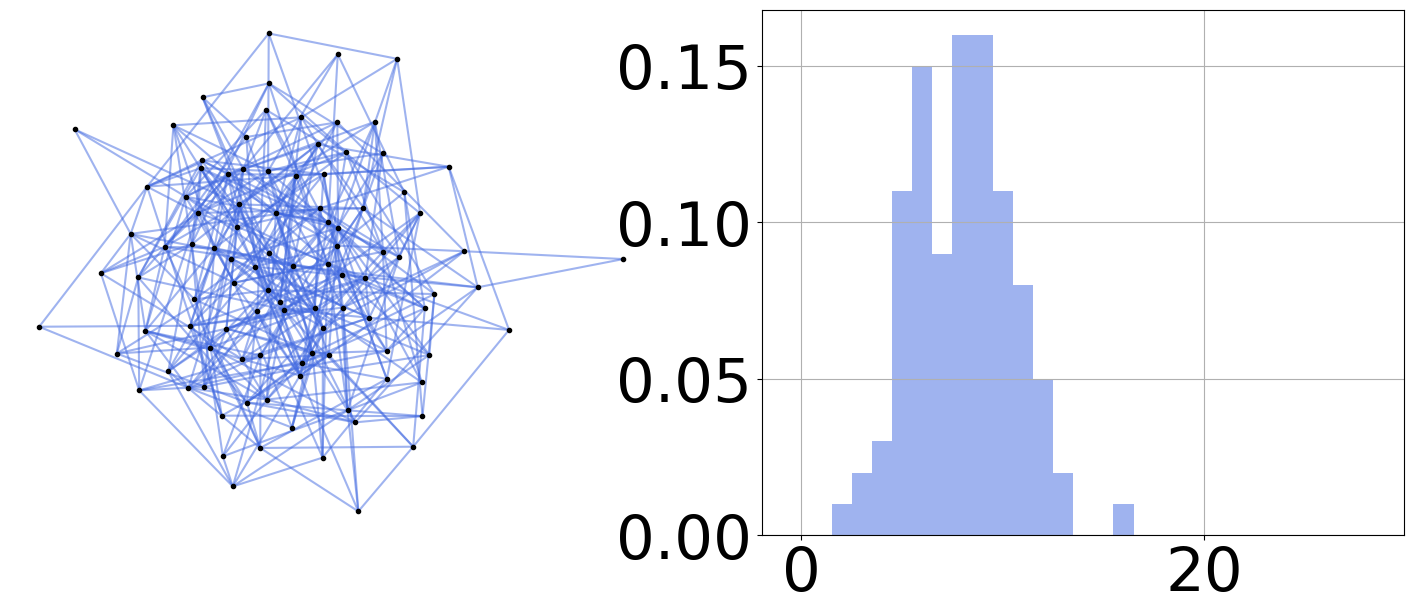

In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import argparse
import modules.random_graph as random_graph
import logging
import modules.weight as weight
import modules.A_mat as A_mat
import modules.pramameters as pramameters
import modules.population as population
import modules.plotGraph as plotGraph
import modules.simulation as simulation
import modules.utils as utils
import modules.nn as mynn
import modules.evaluate as evaluate
import math

#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
#preset
paras.modelLoad= "AA"

#realGraphs= ["contious_Africa", "contious_china", "contious_EU", "contious_usa", "mobility_german", "mobility_us"]
realGraphs2= ["global_air", "us_air"]
realGraphs3= ["us_air100", "us_air200", "us_air300", "us_air400", "spain_bus", "spain_car", "spain_plane", "spain_train"]
paras.randomGraph= "ER"
paras.weightModel= "identical"
paras.epoches= 60000
paras.intense= -1
paras.seed= 10
paras.seed2= 1004
paras.plot= "spring"
if paras.randomGraph== "RGG":
    paras.plot= "2d_RGG"
paras.strains= 1
paras.dense= 0
paras.identicalf= 0.01
paras.n= 100


random.seed(paras.seed)

#results and logs file name
fileName= f"{paras.modelLoad}/{paras.modelLoad}_{paras.randomGraph}_{paras.weightModel}_{paras.seed}_{paras.strains}\
_{paras.intense}_{paras.dense}_{paras.n}_{paras.identicalf*10000}_{paras.epoches}_{paras.seed2}"

printFlag= 1
if printFlag!=1:
    logging.basicConfig(filename="logs/"+paras.modelLoad+".out", level=logging.INFO)

plotFlag= 1

device= paras.device if torch.cuda.is_available() else "cpu"


P= population.population(paras.n, device= device)

if paras.dense<=0:
    paras.dense= int(math.log(paras.n))-paras.dense
    utils.log_print(printFlag, paras.dense)

# generate random graphs: RGG(defult), ER, WS, BA'
if paras.randomGraph=="RGG":
    A, G, pos= random_graph.get_RGG_random_contact(paras.n, paras.dense, device= device)
elif paras.randomGraph=="BA":
    A, G= random_graph.get_BA_random_contact(paras.n, paras.dense, device= device)
elif paras.randomGraph=="WS":
    A, G= random_graph.get_WS_random_contact(paras.n, paras.dense*2, paras.wsProbability, device= device)
elif paras.randomGraph=="ER":
    A, G= random_graph.get_ER_random_contact(paras.n, paras.dense, device= device)
else:
    A, G= random_graph.read_from_file("graphs/"+paras.randomGraph+".npy")
    paras.n= A.shape[0]
    if A.diagonal().sum()> paras.n+1:
        Pop= A.sum(axis=0)+A.sum(axis=1)-A.diagonal()+1e-5
        A= A/Pop
        A= A.fill_diagonal_(0)
        P= torch.tensor(Pop, device= device)
        G = nx.from_numpy_array((A>0.002).numpy())
    else:
        P= population.population(paras.n, device= device)



#assign adjacency weight to matrix: degree(defult), gravity

if paras.weightModel=="degree":
    Aw= weight.degree_model(A, P= P, device=device)
elif  paras.weightModel=="gravity":
    Aw= weight.gravity_model(G, pos, P, device= device)
elif  paras.weightModel=="identical":
    Aw= weight.identical_model(A, paras.identicalf, device= device)
elif  paras.weightModel=="none":
    Aw= A.to(device= device)




G= nx.from_numpy_array((Aw>1e-8).cpu().numpy())
utils.log_print(printFlag,"\n\n\n.........................initialize..........................")
utils.log_print(printFlag,"Device:", device)
utils.log_print(printFlag,"FileName:", fileName)
utils.log_print(printFlag,"Strains:", paras.strains)
utils.log_print(printFlag,"Using", paras.randomGraph, "random graph model")
utils.log_print(printFlag,"Num of nodes:", G.number_of_nodes())
utils.log_print(printFlag,"Num of links:", G.number_of_edges())
Zmat= A_mat.create_A_mat(Aw, P)
Zmat2= A_mat.reverse_A_mat(Zmat-torch.eye(Aw.shape[0], dtype= torch.float32, device= Aw.device), P)
utils.log_print(printFlag,"Reverse ZERO:", torch.sum(torch.abs(Zmat2-Aw)))
utils.log_print(printFlag,"Num links weight bigger than 0.2:", torch.sum(Zmat>0.2)-paras.n)
utils.log_print(printFlag,"Num links weight bigger than 0.1:", torch.sum(Zmat>0.1)-paras.n)
utils.log_print(printFlag,"Num links weight bigger than 0.01:", torch.sum(Zmat>0.01)-paras.n)
utils.log_print(printFlag,".............................................................")
#plot this network  
if plotFlag==1:
    if paras.plot== "2d_RGG":
        plotGraph.plot_spring_and_degree(G, pos= pos)
    elif paras.plot== "spring":
        plotGraph.plot_spring_and_degree(G)

In [8]:
R0s_taus= [[random.uniform(paras.R0Mean-paras.R0Std, paras.R0Mean+paras.R0Std), 
            random.uniform(paras.tauMean-paras.tauStd, paras.tauMean+paras.tauStd)] for _ in range(40)]
paras.R0s=  [ R0s_taus[i][0] for i in range(40)]
paras.taus= [ R0s_taus[i][1] for i in range(40)]
utils.log_print(printFlag,paras.R0s)
utils.log_print(printFlag,paras.taus)
deltaSsTensor, randomList, AmatTransSumSum= simulation.multi_strains(G, paras, Zmat, intense= paras.intense, lower= 20, device= device)
deltaSs= deltaSsTensor.sum(dim= -1, keepdim= True)
propition= deltaSsTensor/(deltaSs+1e-8)
deltaSs= deltaSs.squeeze()#(1, 2, 20), dim of nodes, dim of heads, dim of signal
divide= deltaSsTensor.transpose(1, 2)#-divideCp[:,:, 0:deltaSsTensor.shape[1]]

if plotFlag==0:
    numPlot= 20
    fig, axs = plt.subplots(numPlot, 1, figsize=(20, 5))
    
    for i, ax in enumerate(axs):
        ax.fill(divide[i, :].T.cpu().detach().T.reshape(-1),  color='orange')
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_ylabel(f"{i}")
    plt.ylabel(r"$\Delta \bar S$ for Different Nodes",  loc='bottom')
    plt.xlabel("Time(days)")
    

[8.57981804310741, 8.15031962076312, 8.40021106176579, 8.62074888124137, 7.870243845592106, 7.80976227573839, 8.317920327255294, 7.928697443292416, 8.139717776804604, 8.651348248802774, 8.2029679150196, 7.850458958722219, 7.97307034408713, 8.464756080454451, 7.947062408694553, 8.095136385269006, 8.777291989664558, 8.611375599401745, 8.796747749360414, 8.627057917818624, 8.625851140792141, 8.065684268864372, 8.07861656121736, 8.648662245203983, 8.562931615903862, 8.41454867952728, 8.630495788051258, 8.536613844382176, 8.53016057949267, 8.230759877496553, 8.42062512552645, 8.773303766911267, 8.186485348535763, 8.204658507871574, 8.791189473845765, 8.190609215185548, 8.48141328985609, 8.545784541482735, 8.71491176600198, 7.969318901045592]
[7.417075600469526, 7.514312287002079, 7.518302665077282, 7.43693188732892, 7.478889732708036, 7.4567220284399545, 7.454774688041804, 7.444407482454679, 7.468534800275933, 7.4374550187460375, 7.558676095530815, 7.50275872028857, 7.54683353255735, 7.4374

In [10]:
print(evaluate.pearson_correlation(AmatTransSumSum- torch.diag(AmatTransSumSum), Zmat- torch.diag(Zmat)))

tensor(0.9591, device='cuda:0')


torch.Size([100, 1, 25])


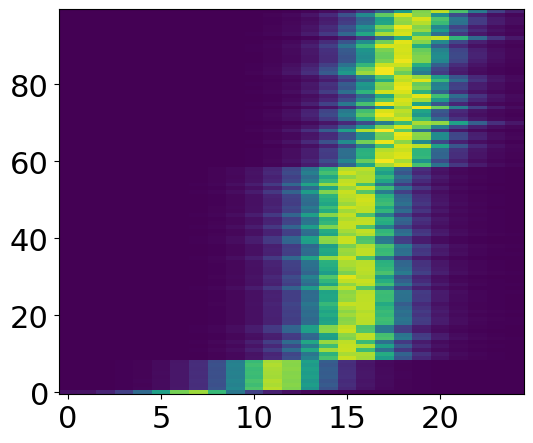

In [11]:
def rank_nodes_by_distance(G, source_node):
    # Get distances from the source_node to all other nodes
    distances = nx.single_source_shortest_path_length(G, source_node)
    # Sort nodes by distance from the source_node
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1])
    # Return sorted nodes by their distance (excluding the distance values)
    return [node for node, _ in sorted_nodes]

print(divide.shape)
nodes_diantance_index= rank_nodes_by_distance(G, randomList[0])

shapeY= divide.shape[0]
shapeX= divide.shape[1]*divide.shape[2]
divide2D= divide.reshape(shapeY, shapeX).cpu().detach()
heatMapDivide2D= divide2D[nodes_diantance_index, :]
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
fontsize= 22
cmap= ax.pcolormesh(range(shapeX), range(shapeY), heatMapDivide2D)
#cbar= fig.colorbar(cmap)

#cbar.ax.tick_params(labelsize= fontsize-7)

# plt.ylabel("Nodes Index",  loc='bottom', fontsize= fontsize)

# plt.xlabel(f"{paras.modelLoad}", fontsize= fontsize)

plt.gca().axes.get_xaxis().set_visible(True)

plt.gca().axes.get_yaxis().set_visible(True)


plt.tick_params(axis='both', labelsize=fontsize)

plt.show()

In [12]:
# paras.seed2= 1004
torch.manual_seed(paras.seed2)
timeHorizon= divide.shape[2]-1
if   paras.modelLoad=="AA":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AsA":
    myMatch= mynn.matchingAs(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AB":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BA":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BB":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="infer2018":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)

    
optimizer1 = torch.optim.Adam(myMatch.parameters(),lr=1e-4)#myMatch.parameters()
optimizer2 = torch.optim.Adam({myEpi.taus},lr=1e-4)
optimizer3 = torch.optim.Adam({myEpi.R0dTaus},lr=1e-4)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []
predError= []
if paras.modelLoad in ["infer2018", "AB", "BB"]:
    threshold_value= 0.1
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.taus.register_hook(hook)
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.R0dTaus.register_hook(hook)

def evaluate_epoch(preZ, methods= []):
    IMatrix= torch.eye(paras.n, device= device)
    preA= A_mat.reverse_A_mat(preZ-IMatrix, P)
    oneResult= []
    for method in methods:
        oneResult.append(method(Aw.cpu(), preA.cpu()))
    return oneResult
evaluateResults= []
PreZs= []

tensor(14.3101, device='cuda:0')


In [41]:
evaluateMeth= [evaluate.spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity,evaluate.ROC_AUC, evaluate.PR_AUC]

if paras.modelLoad== "infer2018":
    for j in tqdm(range(paras.epoches)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        inferZmat= myMatch(divide, paras.modelLoad)
        inferZmat= inferZmat*0.1
        predSignal, signal, PreZ= myEpi(divide, inferZmat)
        tempEye= torch.eye(paras.n, device= device)

        loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()+1e-5*torch.sum(torch.log(torch.sum(PreZ-tempEye, dim= 1)))
        losses.append((loss-1e-5*torch.sum(torch.log(torch.sum(PreZ-tempEye, dim= 1)))).item())
        if torch.isnan(loss).any():
            utils.log_print(printFlag, f"meet nan value at {j}")#
            break
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
        if j%paras.evaluateEvery== 0:
            evaluateResults.append(evaluate_epoch(PreZ.detach(), evaluateMeth))
else:
    for j in tqdm(range(paras.epoches)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        inferZmat= myMatch(divide, paras.modelLoad)
        predSignal, signal, PreZ= myEpi(divide, inferZmat)
        loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()
        if torch.isnan(loss).any():
            utils.log_print(printFlag, f"meet nan value at {j}")#
            break
        error= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])
        errorTmp= myloss(predSignal[:, :, 0:-1] ,signal[:, :, 1:])
        predError.append(errorTmp.item())
        losses.append(error.item())
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
        if j%paras.evaluateEvery== 0:
            evaluateResults.append(evaluate_epoch(PreZ.detach(), evaluateMeth))
            # PreZs.append(inferZmat.detach().clone())

  2%|▏         | 1001/60000 [00:05<05:29, 179.26it/s]


KeyboardInterrupt: 

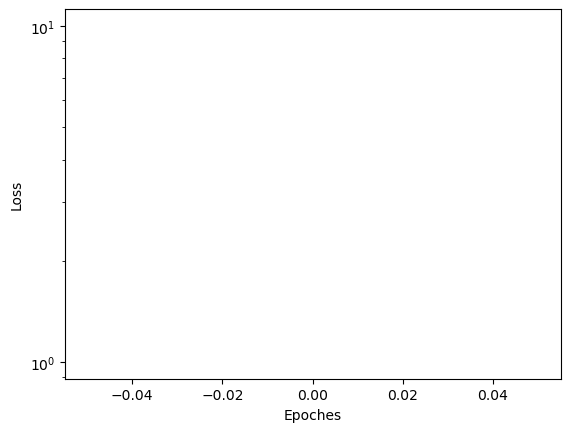

In [13]:
if plotFlag==1:
    plt.plot(predError)
    plt.yscale("log") 
    plt.ylabel("Loss") 
    plt.xlabel("Epoches") 

In [14]:
inferZmatNp= inferZmat.cpu().detach().numpy().squeeze()
pxs= []
pys= []
# Compute histogram
for i in range(2000):
    px= i/1000/50
    py= np.sum(inferZmatNp<px)/10000
    pxs.append(px)
    pys.append(py)
    pass

# Plot the histogram as a probability distribution
plt.figure(figsize=(8, 6))
plt.plot(pxs, pys, linestyle='-', linewidth=2)
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Accumulated Probability Distribution of Data')
plt.grid(True)
plt.show()

NameError: name 'inferZmat' is not defined

In [39]:

#save: A, preA, losses, taus, pretaus, R0s, preR0s, [errors]
utils.log_print(printFlag,paras.taus[0: paras.strains])
utils.log_print(printFlag,paras.R0s[0: paras.strains])
utils.log_print(printFlag,(1+myEpi.taus[0]))
utils.log_print(printFlag,((1+myEpi.taus[0])*myEpi.R0dTaus)[0])

IMatrix= torch.eye(paras.n, device= device)
PreA= A_mat.reverse_A_mat(PreZ-IMatrix, P)


evaluateResults.append(evaluate_epoch(PreZ.squeeze().detach(), evaluateMeth))


utils.log_print(printFlag,"spectral_similarity:", evaluateResults[-1][0])
utils.log_print(printFlag,"pearson_correlation:", evaluateResults[-1][1])
utils.log_print(printFlag,"jaccard_similarity:", evaluateResults[-1][2])
utils.log_print(printFlag,"ROC_AUC:", evaluateResults[-1][3])
utils.log_print(printFlag,"PR_AUC:", evaluateResults[-1][4])
utils.log_print(printFlag,torch.var(myEpi.taus, dim= 0))
utils.log_print(printFlag,torch.var(myEpi.R0dTaus, dim= 0))
startV= 5
deltaV= 7
utils.log_print(printFlag,PreA[startV:startV+deltaV, startV:startV+deltaV])
utils.log_print(printFlag,Aw[startV:startV+deltaV, startV:startV+deltaV])
fileName= f"{paras.modelLoad}/{paras.modelLoad}_{paras.randomGraph}_{paras.weightModel}_{paras.seed}_{paras.strains}\
_{paras.intense}_{paras.dense}_{paras.n}_{paras.identicalf*10000}_{paras.epoches}_{paras.seed2}"
np.savez("results/"+fileName+".npz", A= Aw.cpu().detach(), Apre= PreA.cpu().detach(), 
         cosine_similarity= evaluate.cosine_similarity(Aw, PreA).item(),
         loss= losses, taus= paras.taus, r0s= paras.R0s, tausP= myEpi.taus.cpu().detach(), 
         r0sP= (myEpi.R0dTaus*myEpi.taus).cpu().detach(), signal= signal.cpu().detach(), predSignal= predSignal.cpu().detach(),
           evaluates= evaluateResults)


[7.544338699637052, 7.457993180354814, 7.578291282205388, 7.581443091514427]
[7.9068273143667875, 8.110838272595872, 8.44954326934656, 8.145582275343315]
tensor([7.3827, 7.2936, 7.4019, 7.4041], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([7.7497, 7.9454, 8.2398, 8.0122], device='cuda:0',
       grad_fn=<SelectBackward0>)
spectral_similarity: tensor(0.7606)
pearson_correlation: tensor(0.7909)
jaccard_similarity: tensor(0.5020)
ROC_AUC: 0.8789213675213673
PR_AUC: 0.7958772937028797
tensor([6.8730e-09, 6.6218e-09, 6.6482e-09, 1.2363e-08], device='cuda:0',
       grad_fn=<VarBackward0>)
tensor([7.2216e-07, 7.9973e-07, 2.2631e-06, 6.1410e-06], device='cuda:0',
       grad_fn=<VarBackward0>)
tensor([[0.0000e+00, 5.1019e-03, 1.6844e-05, 5.6965e-04, 1.8792e-05, 1.2559e-04,
         6.1099e-04],
        [9.9506e-03, 0.0000e+00, 2.0408e-05, 1.5372e-04, 2.1607e-05, 1.4440e-06,
         2.4516e-04],
        [3.2749e-07, 2.1734e-07, 0.0000e+00, 2.5622e-07, 8.6984e-03, 5.2829e-07,
      

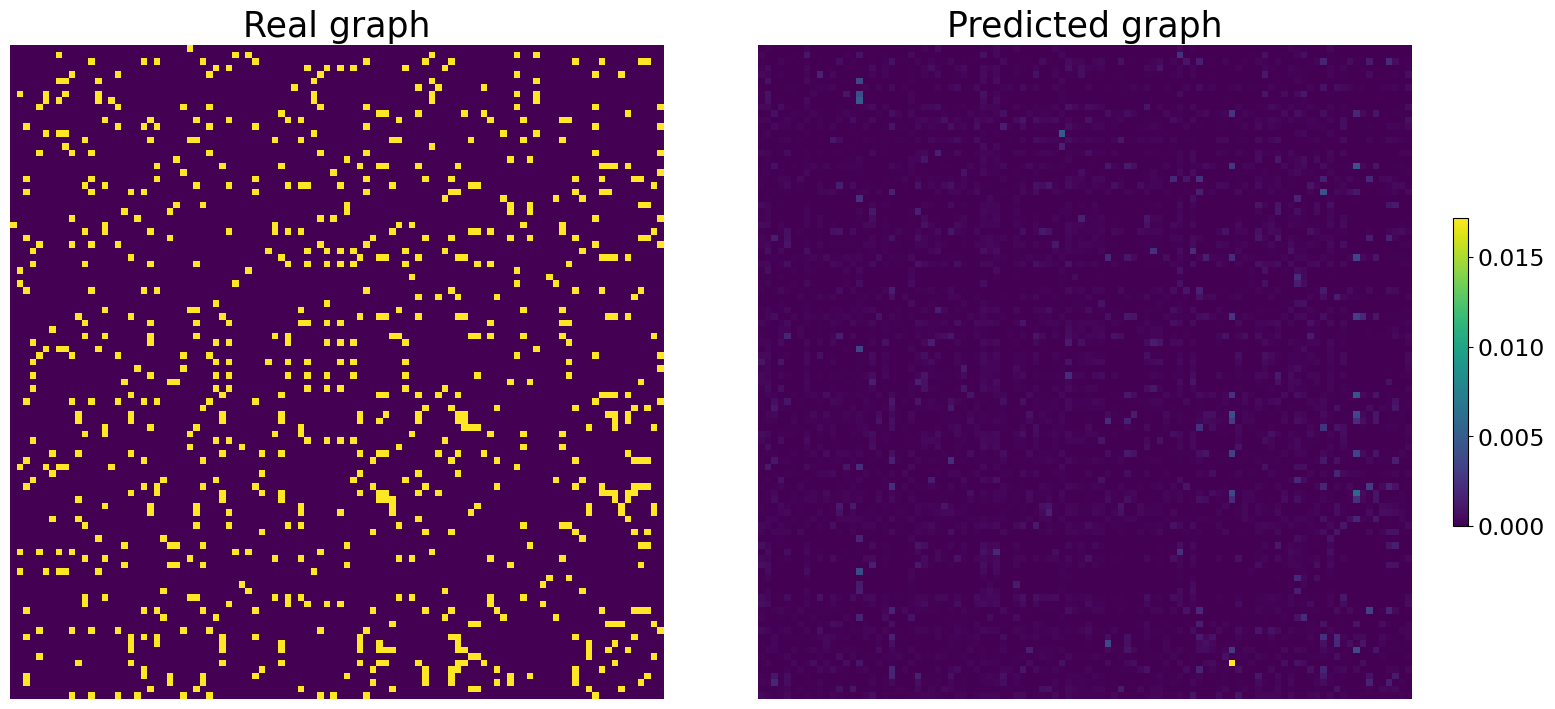

In [9]:
if plotFlag==1:
    plotGraph.plot_adjacenty(A.cpu().detach().numpy(), [ PreA.cpu().detach().numpy()])

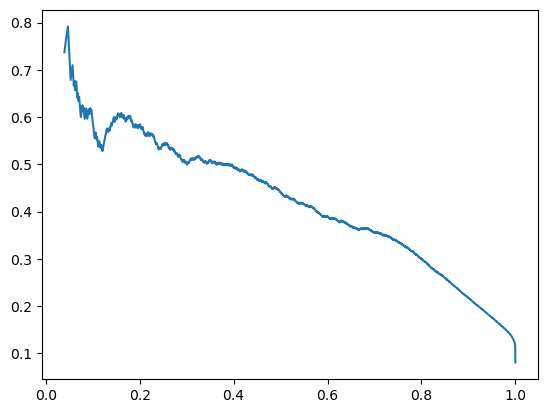

In [65]:
portions= []
xs= []
ATrueNp= A.cpu().detach().numpy()
rankedATrue= np.sort(ATrueNp.flatten())
ATrueNpBi= (ATrueNp>1e-9)*1.0
APreNp= PreA.cpu().detach().numpy()
# APreNp= sumPreA.cpu().detach().numpy()
rankedAPre= np.sort(APreNp.flatten())
for TopNum in range(20, paras.n**2):
    xs.append(((APreNp>rankedAPre[-TopNum])*APreNp).sum()/APreNp.sum())
    APreNpBi=  (APreNp>rankedAPre[-TopNum])*1.0
    portions.append(((ATrueNpBi*APreNpBi).sum())/APreNpBi.sum())
plt.plot(xs, portions)

torch.Size([100, 1, 45])


C:\Users\30678\AppData\Local\Temp\ipykernel_9700\389130381.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  plt.plot(signal[node, :, 1:].squeeze().T.cpu().detach(), label=paras.strains*["true"])


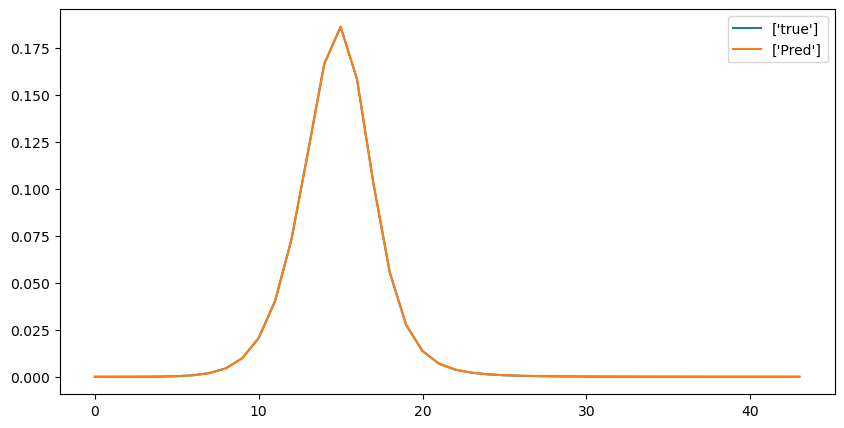

In [39]:
if plotFlag==1:
    node= 1
    plt.figure(figsize=(10, 5))
    plt.plot(signal[node, :, 1:].squeeze().T.cpu().detach(), label=paras.strains*["true"])
    plt.plot(predSignal[node, :, 0:-1].squeeze().T.cpu().detach(), label=paras.strains*["Pred"])
    plt.legend()
    print(signal.shape)

In [31]:
# read for error analysis
seed2s= list(range(1000, 1010))
preAs= []
sumPreA= 0
paras.dense= 4
countTmp= 0
Pearsons= []
paras.randomGraph= "BA"
paras.seed= 10
paras.epoches= 150000
paras.strains= 1
parametersP= []
for seed2 in seed2s:
    countTmp+= 1
    fileName=f"AA/AA_{paras.randomGraph}_{paras.weightModel}_{paras.seed}_{paras.strains}_{-1}_0_{paras.n}_{paras.identicalf*1000}_{paras.epoches}_{seed2}"
    npzfile = np.load("results/"+fileName+".npz")
    PreA= torch.tensor(npzfile["Apre"]).to(device= device)
    AdjCurTen= torch.tensor(npzfile["A"]).to(device= device)
    signal= torch.tensor(npzfile["signal"]).to(device= device)
    predSignal= torch.tensor(npzfile["predSignal"]).to(device= device)
    lossHere= npzfile["loss"][-1]
    taus= np.mean(npzfile["taus"])
    r0s= np.mean(npzfile["r0s"])/(np.mean(npzfile["taus"])+1e-8)
    tausP= np.mean(npzfile["tausP"])+1.01
    r0sp= np.mean(npzfile["r0sP"])/(np.mean(npzfile["tausP"])+1e-8)
    if lossHere<1e-4:
        parametersP.append([tausP, r0sp])
        sumPreA+= PreA
        preAs.append(PreA)
        sumPreATmp= sumPreA/countTmp
        Pearsons.append(np.round(evaluate.pearson_correlation(sumPreATmp, AdjCurTen).item(),3))
sumPreA= sumPreA/len(preAs)
preAs.append(sumPreA)
preAs.append(AdjCurTen)
for i in preAs:
    for j in preAs:
        print(np.round(evaluate.pearson_correlation(i, j).item(),3), end= "    ")
    print()
print(parametersP)
print(taus, " ", r0s)

1.0    0.953    0.917    0.889    0.957    0.959    0.933    0.944    0.977    0.335    
0.953    1.0    0.887    0.864    0.932    0.956    0.91    0.945    0.962    0.345    
0.917    0.887    1.0    0.931    0.932    0.908    0.953    0.862    0.962    0.27    
0.889    0.864    0.931    1.0    0.919    0.88    0.935    0.838    0.946    0.247    
0.957    0.932    0.932    0.919    1.0    0.947    0.945    0.911    0.978    0.309    
0.959    0.956    0.908    0.88    0.947    1.0    0.923    0.935    0.971    0.327    
0.933    0.91    0.953    0.935    0.945    0.923    1.0    0.885    0.972    0.283    
0.944    0.945    0.862    0.838    0.911    0.935    0.885    1.0    0.944    0.35    
0.977    0.962    0.962    0.946    0.978    0.971    0.972    0.944    1.0    0.316    
0.335    0.345    0.27    0.247    0.309    0.327    0.283    0.35    0.316    1.0    
[[7.423380146026611, 1.1064579000197174], [7.427703151702881, 1.1068697355398283], [7.39491678237915, 1.10557416660619

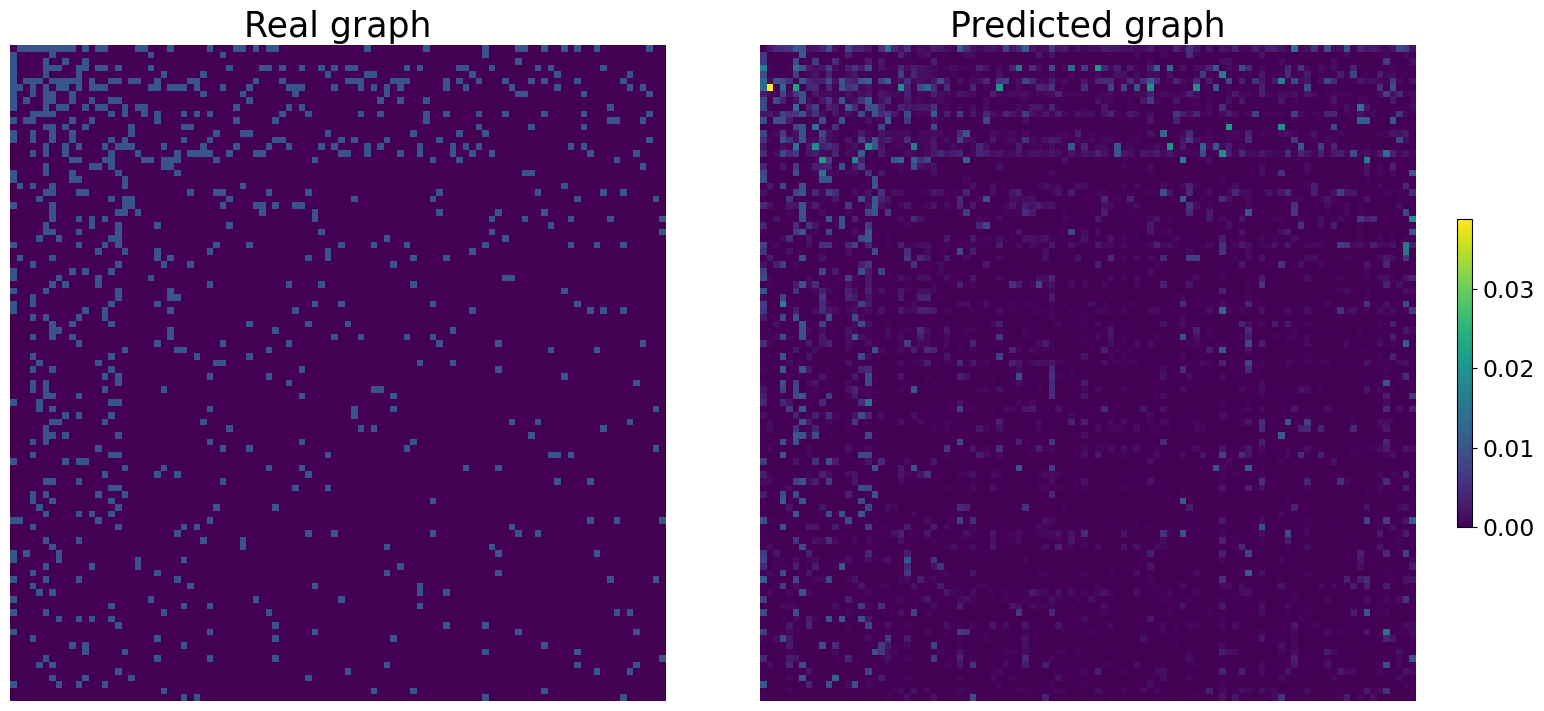

In [16]:
plotGraph.plot_adjacenty(AdjCurTen.cpu().detach().numpy(), [ sumPreA.cpu().detach().numpy()])

In [ ]:
n= sumPreA.shape[0]
print(torch.argmax(sumPreA)//(n), torch.argmax(sumPreA)%(n))
print(torch.max(sumPreA))

tensor(6, device='cuda:0') tensor(1, device='cuda:0')
tensor(0.0388, device='cuda:0')


[<matplotlib.lines.Line2D object at 0x000001E98B3C2FD0>, <matplotlib.lines.Line2D object at 0x000001E98B3C3350>, <matplotlib.lines.Line2D object at 0x000001E98B3C3550>, <matplotlib.lines.Line2D object at 0x000001E98B3C3990>, <matplotlib.lines.Line2D object at 0x000001E98B3C3CD0>, <matplotlib.lines.Line2D object at 0x000001E98B3CC110>, <matplotlib.lines.Line2D object at 0x000001E98B3CC550>, <matplotlib.lines.Line2D object at 0x000001E98B3CCA90>, <matplotlib.lines.Line2D object at 0x000001E98B3C3DD0>, <matplotlib.lines.Line2D object at 0x000001E98B3CD2D0>, <matplotlib.lines.Line2D object at 0x000001E98B3CD610>, <matplotlib.lines.Line2D object at 0x000001E98B3CD990>, <matplotlib.lines.Line2D object at 0x000001E98B3CDD10>, <matplotlib.lines.Line2D object at 0x000001E98B3B6090>, <matplotlib.lines.Line2D object at 0x000001E98B3C01D0>, <matplotlib.lines.Line2D object at 0x000001E98B37FC50>, <matplotlib.lines.Line2D object at 0x000001E98B2B8E50>, <matplotlib.lines.Line2D object at 0x000001E98B

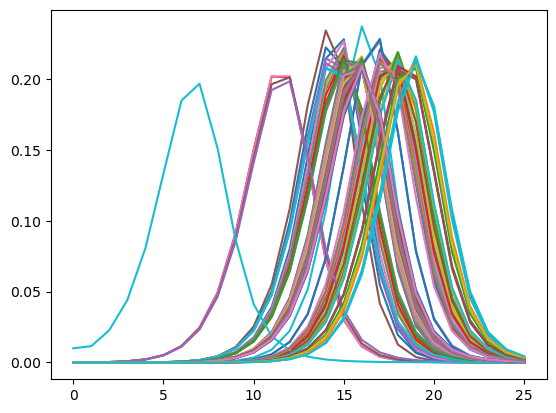

In [24]:
print(plt.plot(signal.cpu().numpy().squeeze().T[:, 3, :]))